# 全局变量，文件地址

In [ ]:
# =========================
# Global configuration
# =========================

# 根目录
BASE_DIR = r"N:\08_NK_structure_prediction\data\COPI_complex"

# 输入文件
USEQS_CSV = f"{BASE_DIR}/assembled_complex/useqs.csv"
RESIDUE_PAIR_CSV = (
    f"{BASE_DIR}/heklopit_pl3017_frd1ppi_sc151_fdr1rp_COPI_cleaned.csv"
)

# 中间文件
UCROSSLINKS_CSV = f"{BASE_DIR}/assembled_complex/ucrosslinks.csv"
CHAINS_CSV = f"{BASE_DIR}/assembled_complex/chains.csv"

# AlphaFold 预测
AF_PRED_DIR = f"{BASE_DIR}/afx_pred"

# 组装用文件
NETWORK_CSV = f"{BASE_DIR}/assembled_complex/network.csv"
PAIRS_DIR = f"{BASE_DIR}/assembled_complex/pairs"

# 输出
REWRITED_PDB_DIR = f"{BASE_DIR}/assembled_complex/rewrited_pdbs"
OUTPUT_DIR = f"{BASE_DIR}/assembled_complex/output"

# 导入依赖

In [2]:
import argparse
import logging
import pandas as pd

from complex_assembly.rewrite_af_files import *
from complex_assembly.mcts import main
from preprocess.crosslink_prepare import *
from preprocess.network_prepare import build_network_and_useqs
from network.interact_map import *

# 手动写入chains.csv文件

```text
Entry	Gene	Chain
Q8WUH2	TGFBRAP1	A
Q9H270	VPS11	B

请确保：

文件为 Tab 分隔（TSV） 或在保存为 CSV 时分隔符一致

列名必须严格为：Entry、Gene、Chain

Chain 通常使用单个大写字母（A、B、C…）

# 手动准备相应fasta文件

FASTA 文件需包含对应 Gene 的蛋白序列，且 描述行中必须包含 GN= 字段，例如：

>sp|Q8WUH2|TGFBRAP1_HUMAN Transforming growth factor beta receptor-associated protein 1 OS=Homo sapiens GN=TGFBRAP1 PE=1 SV=2
MSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...

>sp|Q9H270|VPS11_HUMAN Vacuolar protein sorting-associated protein 11 OS=Homo sapiens GN=VPS11 PE=1 SV=1
MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...

请注意：

GN= 后的基因名必须与 chains.csv 中的 Gene 列 完全一致

每个 Gene 只需一条序列

支持标准 UniProt FASTA 格式

In [ ]:
# ====== 读取数据并构建网络 ======
df = load_interaction_data(RESIDUE_PAIR_CSV)
G = build_ppi_network(df)

# ====== 打印需要清洗的节点 ======
dirty_nodes = [n for n in G.nodes() if ";" in str(n)]
print("Nodes needing cleanup:", dirty_nodes)

Nodes needing cleanup: ['COPB2; COPB2', 'ASS1; ARCN1', 'COPB1; COPB1', 'COPA; COPA', 'COPB1; COPB1; COPB1; COPB1', 'ARF4; ARF6; ARF1; ARF5', 'COPG2; COPG1', 'COPZ1; COPZ1']


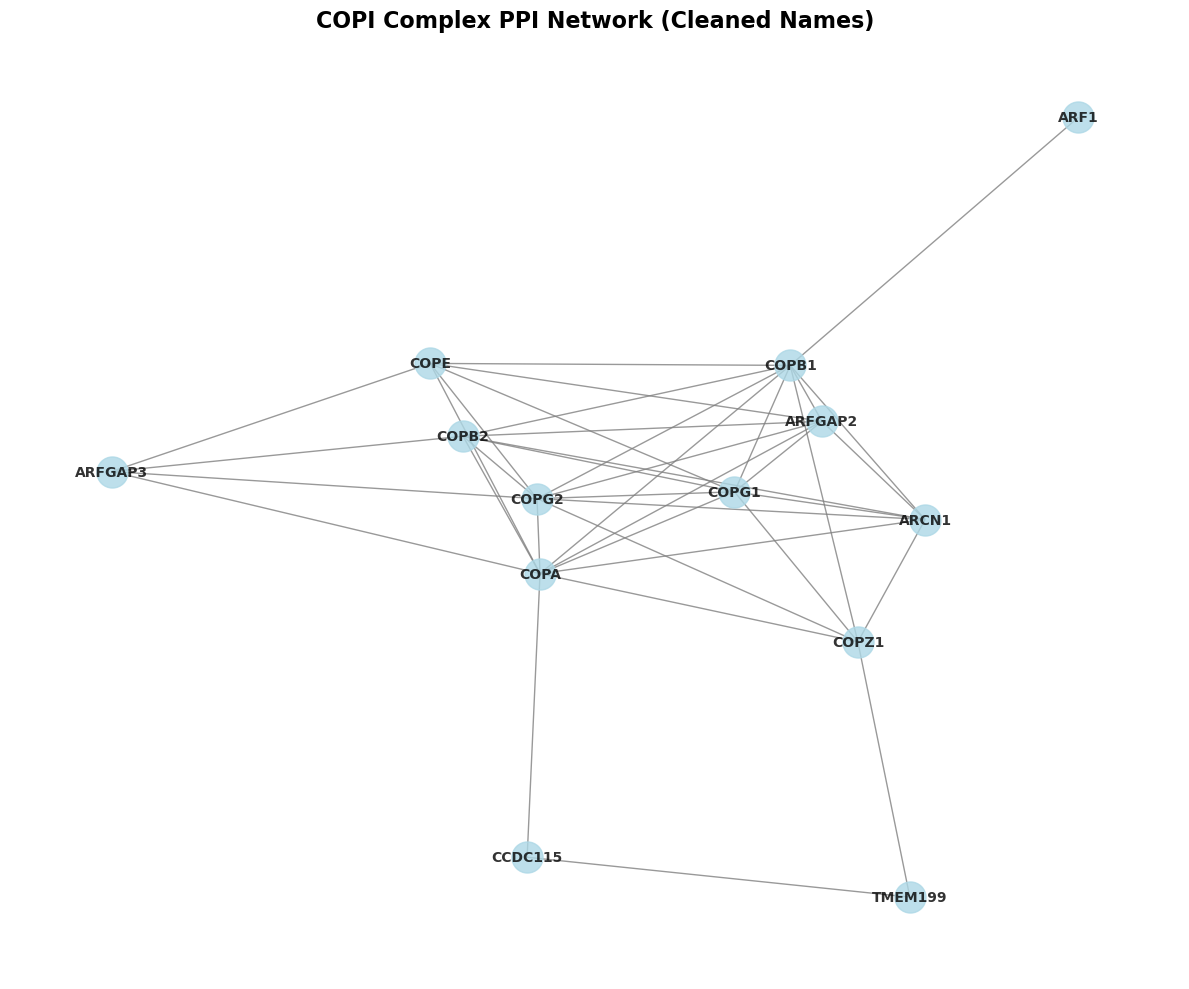

清洗完成： N:\08_NK_structure_prediction\data\COPI_complex\heklopit_pl3017_frd1ppi_sc151_fdr1rp_COPI_cleaned.csv
Total triplets: 120
Triplets found in PPI: 73


In [ ]:
# ====== 清洗节点名称 ======
manual_map = {
    'COPB2; COPB2':'COPB2', 
    'ASS1; ARCN1':'ARCN1', 
    'COPB1; COPB1':'COPB1', 
    'COPA; COPA':'COPA', 
    'COPB1; COPB1; COPB1; COPB1':'COPB1', 
    'ARF4; ARF6; ARF1; ARF5':'ARF1', 
    'COPG2; COPG1':'COPG1', 
    'COPZ1; COPZ1':'COPZ1'
}
G = clean_node_names(G, manual_map)

# ====== 绘图 ======
plot_ppi_network(G, "COPI Complex PPI Network (Cleaned Names)")

# 重新清理原文件
clean_residue_pair_file(input_path, manual_map)

# ====== 复合体分析 ======
protein_list = ["COPB1",
                "COPZ1",
                "COPG1",
                "ARCN1",
                "COPE",
                "COPB2",
                "COPA",
                "ARF1",
                "ARFGAP2",
                "ARFGAP3"
                ]
binary_pairs_in_ppi, triplet_in_ppi = analyze_complexes(G, protein_list)

# ====== 输出结果 ======
df_binary_ppi = pd.DataFrame(set(binary_pairs_in_ppi), columns=["p1", "p2"])
df_binary_ppi.to_csv(os.path.join(OUTPUT_DIR,"binary_pairs_in_ppi.csv"), index=False)

df_triplet_ppi = pd.DataFrame(set(triplet_in_ppi), columns=["p1", "p2", "p3"])
df_triplet_ppi.to_csv(os.path.join(OUTPUT_DIR,"triplet_need_to_pred.csv"), index=False)

print(f"Total triplets: {len(list(combinations(protein_list, 3)))}")
print(f"Triplets found in PPI: {len(triplet_in_ppi)}")

In [44]:
# useq and network
network_df, useq_df = build_network_and_useqs(
    binary_csv=r"N:\08_NK_structure_prediction\data\COPI_complex\binary_pairs_in_ppi.csv",
    chains_csv=CHAINS_CSV,
    fasta_file=r"N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\COPI.fasta",
    network_out=NETWORK_CSV,
    useqs_out=USEQS_CSV
)

# Step 1 — 准备 crosslinks

In [45]:
# STEP 1: Prepare ucrosslinks

useq_df = pd.read_csv(USEQS_CSV)
residue_pair_df = pd.read_csv(RESIDUE_PAIR_CSV)

ucrosslinks = crosslink_prepare(useq_df, residue_pair_df)
ucrosslinks.to_csv(UCROSSLINKS_CSV, index=False)

print("✔ ucrosslinks written to:", UCROSSLINKS_CSV)

✔ ucrosslinks written to: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/ucrosslinks.csv


# Step 2 — 重写 PDB / score

In [ ]:
# STEP 2: Rewrite AF PDB and score files

# rewrite_af_cif_structure(
#     af_pred_folder=AF_PRED_DIR,
#     chains_df_path=CHAINS_CSV,
#     output_folder=REWRITED_PDB_DIR,
# )

# print("✔ AF PDB rewritten")

Gene -> Chain mapping: {'copb1': 'A', 'copz1': 'B', 'copg1': 'C', 'arcn1': 'D', 'cope': 'E', 'copb2': 'F', 'copa': 'G', 'arf1': 'H', 'arfgap2': 'J', 'arfgap3': 'K', 'ccdc115': 'L', 'tmem199': 'M'}
Folder: copa_arfgap3_ccdc115_1, mapping: {'A': 'G', 'B': 'K', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_arfgap3_ccdc115_1\copa_arfgap3_ccdc115_1.pdb
Folder: copb2_copz1_copg1_1, mapping: {'A': 'F', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copz1_copg1_1\copb2_copz1_copg1_1.pdb
Folder: arcn1_copa_cope_1, mapping: {'A': 'D', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_cope_1\arcn1_copa_cope_1.pdb
Folder: arfgap2_copa_copz1_2, mapping: {'A': 'J', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copz1_2\arfgap2_copa_copz1_2.pdb
Folder: arfgap2_copa_cope_0, mapping: {'A': 'J', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_cope_0\arfgap2_copa_cope_0.pdb
Folder: copa_copg1_1, mapping: {'A': 'G', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_1\copa_copg1_1.pdb
Folder: copa_ccdc115_tmem199_2, mapping: {'A': 'G', 'B': 'L', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_ccdc115_tmem199_2\copa_ccdc115_tmem199_2.pdb
Folder: copb2_copa_2, mapping: {'A': 'F', 'B': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_2\copb2_copa_2.pdb
Folder: arcn1_arfgap2_cope_1, mapping: {'A': 'D', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_cope_1\arcn1_arfgap2_cope_1.pdb
Folder: arfgap2_copg1_cope_0, mapping: {'A': 'J', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copg1_cope_0\arfgap2_copg1_cope_0.pdb
Folder: copa_ccdc115_tmem199_1, mapping: {'A': 'G', 'B': 'L', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_ccdc115_tmem199_1\copa_ccdc115_tmem199_1.pdb
Folder: copb2_arfgap2_cope_1, mapping: {'A': 'F', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_cope_1\copb2_arfgap2_cope_1.pdb
Folder: arfgap2_cope_arfgap3_0, mapping: {'A': 'J', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_cope_arfgap3_0\arfgap2_cope_arfgap3_0.pdb
Folder: copb2_copg1_2, mapping: {'A': 'F', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_2\copb2_copg1_2.pdb
Folder: copb2_copa_ccdc115_2, mapping: {'A': 'F', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_ccdc115_2\copb2_copa_ccdc115_2.pdb
Folder: arcn1_arfgap2_cope_0, mapping: {'A': 'D', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_cope_0\arcn1_arfgap2_cope_0.pdb
Folder: copb2_cope_arfgap3_0, mapping: {'A': 'F', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_cope_arfgap3_0\copb2_cope_arfgap3_0.pdb
Folder: copb2_copg1_cope_2, mapping: {'A': 'F', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_cope_2\copb2_copg1_cope_2.pdb
Folder: arcn1_copa_arfgap3_1, mapping: {'A': 'D', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_arfgap3_1\arcn1_copa_arfgap3_1.pdb
Folder: arcn1_arfgap2_copa_0, mapping: {'A': 'D', 'B': 'J', 'C': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `C` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copa_0\arcn1_arfgap2_copa_0.pdb
Folder: arcn1_arfgap2_copg1_1, mapping: {'A': 'D', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copg1_1\arcn1_arfgap2_copg1_1.pdb
Folder: arcn1_copa_cope_0, mapping: {'A': 'D', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_cope_0\arcn1_copa_cope_0.pdb
Folder: arfgap2_copa_copg1_2, mapping: {'A': 'J', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copg1_2\arfgap2_copa_copg1_2.pdb
Folder: arcn1_copa_copz1_0, mapping: {'A': 'D', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copz1_0\arcn1_copa_copz1_0.pdb
Folder: copb2_arfgap2_copg1_1, mapping: {'A': 'F', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_copg1_1\copb2_arfgap2_copg1_1.pdb
Folder: arcn1_copg1_cope_1, mapping: {'A': 'D', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copg1_cope_1\arcn1_copg1_cope_1.pdb
Folder: copa_copg1_arfgap3_0, mapping: {'A': 'G', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_arfgap3_0\copa_copg1_arfgap3_0.pdb
Folder: arcn1_arfgap2_copg1_2, mapping: {'A': 'D', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copg1_2\arcn1_arfgap2_copg1_2.pdb
Folder: arcn1_arfgap2_copz1_2, mapping: {'A': 'D', 'B': 'J', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copz1_2\arcn1_arfgap2_copz1_2.pdb
Folder: arfgap2_copg1_cope_1, mapping: {'A': 'J', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copg1_cope_1\arfgap2_copg1_cope_1.pdb
Folder: arcn1_copz1_tmem199_2, mapping: {'A': 'D', 'B': 'B', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_tmem199_2\arcn1_copz1_tmem199_2.pdb
Folder: copa_cope_ccdc115_2, mapping: {'A': 'G', 'B': 'E', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_ccdc115_2\copa_cope_ccdc115_2.pdb
Folder: copz1_copg1_tmem199_1, mapping: {'A': 'B', 'B': 'C', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_copg1_tmem199_1\copz1_copg1_tmem199_1.pdb
Folder: arfgap2_copa_ccdc115_2, mapping: {'A': 'J', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_ccdc115_2\arfgap2_copa_ccdc115_2.pdb
Folder: copb2_arfgap2_copg1_2, mapping: {'A': 'F', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_copg1_2\copb2_arfgap2_copg1_2.pdb
Folder: copa_copz1_arfgap3_1, mapping: {'A': 'G', 'B': 'B', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_arfgap3_1\copa_copz1_arfgap3_1.pdb
Folder: copb2_arfgap2_copg1_0, mapping: {'A': 'F', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_copg1_0\copb2_arfgap2_copg1_0.pdb
Folder: copz1_copg1_cope_2, mapping: {'A': 'B', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_copg1_cope_2\copz1_copg1_cope_2.pdb
Folder: copz1_ccdc115_tmem199_0, mapping: {'A': 'B', 'B': 'L', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_ccdc115_tmem199_0\copz1_ccdc115_tmem199_0.pdb
Folder: copa_copg1_ccdc115_1, mapping: {'A': 'G', 'B': 'C', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_ccdc115_1\copa_copg1_ccdc115_1.pdb
Folder: copb2_copa_arfgap3_2, mapping: {'A': 'F', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_arfgap3_2\copb2_copa_arfgap3_2.pdb
Folder: arfgap2_copz1_copg1_0, mapping: {'A': 'J', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copz1_copg1_0\arfgap2_copz1_copg1_0.pdb
Folder: copa_copg1_ccdc115_2, mapping: {'A': 'G', 'B': 'C', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_ccdc115_2\copa_copg1_ccdc115_2.pdb
Folder: copa_copz1_cope_0, mapping: {'A': 'G', 'B': 'B', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_cope_0\copa_copz1_cope_0.pdb
Folder: copb2_copg1_cope_0, mapping: {'A': 'F', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_cope_0\copb2_copg1_cope_0.pdb
Folder: arfgap2_copa_ccdc115_1, mapping: {'A': 'J', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_ccdc115_1\arfgap2_copa_ccdc115_1.pdb
Folder: arfgap2_copa_arfgap3_1, mapping: {'A': 'J', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_arfgap3_1\arfgap2_copa_arfgap3_1.pdb
Folder: arfgap2_copg1_cope_2, mapping: {'A': 'J', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copg1_cope_2\arfgap2_copg1_cope_2.pdb
Folder: arcn1_arfgap2_copz1_0, mapping: {'A': 'D', 'B': 'J', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copz1_0\arcn1_arfgap2_copz1_0.pdb
Folder: arcn1_copa_cope_2, mapping: {'A': 'D', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_cope_2\arcn1_copa_cope_2.pdb
Folder: copa_cope_ccdc115_0, mapping: {'A': 'G', 'B': 'E', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_ccdc115_0\copa_cope_ccdc115_0.pdb
Folder: arcn1_arfgap2_copa_2, mapping: {'A': 'D', 'B': 'J', 'C': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `C` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copa_2\arcn1_arfgap2_copa_2.pdb
Folder: arfgap2_copa_arfgap3_2, mapping: {'A': 'J', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_arfgap3_2\arfgap2_copa_arfgap3_2.pdb
Folder: copa_copz1_copg1_1, mapping: {'A': 'G', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_copg1_1\copa_copz1_copg1_1.pdb
Folder: copa_copg1_arfgap3_1, mapping: {'A': 'G', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_arfgap3_1\copa_copg1_arfgap3_1.pdb
Folder: arcn1_copa_ccdc115_0, mapping: {'A': 'D', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `L` is already used for a sibling of this entity. Changing id from `C` to `L` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_ccdc115_0\arcn1_copa_ccdc115_0.pdb
Folder: arcn1_copz1_copg1_2, mapping: {'A': 'D', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_copg1_2\arcn1_copz1_copg1_2.pdb
Folder: arcn1_arfgap2_copa_1, mapping: {'A': 'D', 'B': 'J', 'C': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `C` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copa_1\arcn1_arfgap2_copa_1.pdb
Folder: copa_copg1_cope_2, mapping: {'A': 'G', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_cope_2\copa_copg1_cope_2.pdb
Folder: copb2_copa_copz1_2, mapping: {'A': 'F', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_copz1_2\copb2_copa_copz1_2.pdb
Folder: copg1_cope_arfgap3_2, mapping: {'A': 'C', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `A` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copg1_cope_arfgap3_2\copg1_cope_arfgap3_2.pdb
Folder: copb2_arfgap2_cope_2, mapping: {'A': 'F', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_cope_2\copb2_arfgap2_cope_2.pdb
Folder: arfgap2_copz1_copg1_1, mapping: {'A': 'J', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copz1_copg1_1\arfgap2_copz1_copg1_1.pdb
Folder: copa_copz1_cope_2, mapping: {'A': 'G', 'B': 'B', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_cope_2\copa_copz1_cope_2.pdb
Folder: arcn1_copa_ccdc115_1, mapping: {'A': 'D', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `L` is already used for a sibling of this entity. Changing id from `C` to `L` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_ccdc115_1\arcn1_copa_ccdc115_1.pdb
Folder: arfgap2_copa_copz1_1, mapping: {'A': 'J', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copz1_1\arfgap2_copa_copz1_1.pdb
Folder: arcn1_copa_copz1_2, mapping: {'A': 'D', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copz1_2\arcn1_copa_copz1_2.pdb
Folder: copb1_arcn1_arf1_2, mapping: {'A': 'A', 'B': 'D', 'C': 'H'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `H` is already used for a sibling of this entity. Changing id from `C` to `H` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arf1_2\copb1_arcn1_arf1_2.pdb
Folder: arcn1_copg1_cope_2, mapping: {'A': 'D', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copg1_cope_2\arcn1_copg1_cope_2.pdb
Folder: copa_copg1_ccdc115_0, mapping: {'A': 'G', 'B': 'C', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_ccdc115_0\copa_copg1_ccdc115_0.pdb
Folder: arfgap2_copa_cope_1, mapping: {'A': 'J', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_cope_1\arfgap2_copa_cope_1.pdb
Folder: copa_copg1_cope_0, mapping: {'A': 'G', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_cope_0\copa_copg1_cope_0.pdb
Folder: arfgap2_cope_arfgap3_1, mapping: {'A': 'J', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_cope_arfgap3_1\arfgap2_cope_arfgap3_1.pdb
Folder: copa_copz1_arfgap3_0, mapping: {'A': 'G', 'B': 'B', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_arfgap3_0\copa_copz1_arfgap3_0.pdb
Folder: copa_cope_arfgap3_2, mapping: {'A': 'G', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_arfgap3_2\copa_cope_arfgap3_2.pdb
Folder: arcn1_copa_arfgap3_0, mapping: {'A': 'D', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_arfgap3_0\arcn1_copa_arfgap3_0.pdb
Folder: arcn1_copa_arfgap3_2, mapping: {'A': 'D', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_arfgap3_2\arcn1_copa_arfgap3_2.pdb
Folder: arcn1_arfgap2_copz1_1, mapping: {'A': 'D', 'B': 'J', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copz1_1\arcn1_arfgap2_copz1_1.pdb
Folder: copb1_arcn1_arf1_0, mapping: {'A': 'A', 'B': 'D', 'C': 'H'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `H` is already used for a sibling of this entity. Changing id from `C` to `H` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arf1_0\copb1_arcn1_arf1_0.pdb
Folder: copb2_copa_ccdc115_0, mapping: {'A': 'F', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_ccdc115_0\copb2_copa_ccdc115_0.pdb
Folder: copb1_arcn1_arf1_1, mapping: {'A': 'A', 'B': 'D', 'C': 'H'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `H` is already used for a sibling of this entity. Changing id from `C` to `H` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arf1_1\copb1_arcn1_arf1_1.pdb
Folder: copa_copz1_tmem199_2, mapping: {'A': 'G', 'B': 'B', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_tmem199_2\copa_copz1_tmem199_2.pdb
Folder: copb2_copa_copz1_1, mapping: {'A': 'F', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_copz1_1\copb2_copa_copz1_1.pdb
Folder: copb2_copa_0, mapping: {'A': 'F', 'B': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_0\copb2_copa_0.pdb
Folder: copa_copz1_tmem199_1, mapping: {'A': 'G', 'B': 'B', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_tmem199_1\copa_copz1_tmem199_1.pdb
Folder: arfgap2_copz1_copg1_2, mapping: {'A': 'J', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copz1_copg1_2\arfgap2_copz1_copg1_2.pdb
Folder: copb2_copg1_cope_1, mapping: {'A': 'F', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_cope_1\copb2_copg1_cope_1.pdb
Folder: copg1_cope_arfgap3_1, mapping: {'A': 'C', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `A` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copg1_cope_arfgap3_1\copg1_cope_arfgap3_1.pdb
Folder: copb2_cope_arfgap3_2, mapping: {'A': 'F', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_cope_arfgap3_2\copb2_cope_arfgap3_2.pdb
Folder: arfgap2_copa_copg1_0, mapping: {'A': 'J', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copg1_0\arfgap2_copa_copg1_0.pdb
Folder: arfgap2_copa_arfgap3_0, mapping: {'A': 'J', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_arfgap3_0\arfgap2_copa_arfgap3_0.pdb
Folder: copb2_copa_cope_1, mapping: {'A': 'F', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_cope_1\copb2_copa_cope_1.pdb
Folder: copa_arfgap3_ccdc115_0, mapping: {'A': 'G', 'B': 'K', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_arfgap3_ccdc115_0\copa_arfgap3_ccdc115_0.pdb
Folder: copb2_copg1_1, mapping: {'A': 'F', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_1\copb2_copg1_1.pdb
Folder: copb2_copa_copz1_0, mapping: {'A': 'F', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_copz1_0\copb2_copa_copz1_0.pdb
Folder: copb2_copz1_copg1_2, mapping: {'A': 'F', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copz1_copg1_2\copb2_copz1_copg1_2.pdb
Folder: arcn1_copg1_cope_0, mapping: {'A': 'D', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copg1_cope_0\arcn1_copg1_cope_0.pdb
Folder: copa_copz1_arfgap3_2, mapping: {'A': 'G', 'B': 'B', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_arfgap3_2\copa_copz1_arfgap3_2.pdb
Folder: arcn1_copa_ccdc115_2, mapping: {'A': 'D', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `L` is already used for a sibling of this entity. Changing id from `C` to `L` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_ccdc115_2\arcn1_copa_ccdc115_2.pdb
Folder: copa_copg1_2, mapping: {'A': 'G', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_2\copa_copg1_2.pdb
Folder: arcn1_copa_copg1_1, mapping: {'A': 'D', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copg1_1\arcn1_copa_copg1_1.pdb
Folder: copa_arfgap3_ccdc115_2, mapping: {'A': 'G', 'B': 'K', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_arfgap3_ccdc115_2\copa_arfgap3_ccdc115_2.pdb
Folder: copa_copz1_ccdc115_0, mapping: {'A': 'G', 'B': 'B', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_ccdc115_0\copa_copz1_ccdc115_0.pdb
Folder: copb2_copa_arfgap3_1, mapping: {'A': 'F', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_arfgap3_1\copb2_copa_arfgap3_1.pdb
Folder: copa_copz1_copg1_2, mapping: {'A': 'G', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_copg1_2\copa_copz1_copg1_2.pdb
Folder: arcn1_copz1_copg1_1, mapping: {'A': 'D', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_copg1_1\arcn1_copz1_copg1_1.pdb
Folder: copa_copg1_cope_1, mapping: {'A': 'G', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_cope_1\copa_copg1_cope_1.pdb
Folder: arcn1_copz1_tmem199_0, mapping: {'A': 'D', 'B': 'B', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_tmem199_0\arcn1_copz1_tmem199_0.pdb
Folder: copb2_copg1_0, mapping: {'A': 'F', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_0\copb2_copg1_0.pdb
Folder: copa_copz1_cope_1, mapping: {'A': 'G', 'B': 'B', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_cope_1\copa_copz1_cope_1.pdb
Folder: arcn1_copz1_tmem199_1, mapping: {'A': 'D', 'B': 'B', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_tmem199_1\arcn1_copz1_tmem199_1.pdb
Folder: copb2_copg1_arfgap3_0, mapping: {'A': 'F', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_arfgap3_0\copb2_copg1_arfgap3_0.pdb
Folder: arcn1_copz1_copg1_0, mapping: {'A': 'D', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copz1_copg1_0\arcn1_copz1_copg1_0.pdb
Folder: copz1_copg1_cope_0, mapping: {'A': 'B', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_copg1_cope_0\copz1_copg1_cope_0.pdb
Folder: copz1_copg1_tmem199_0, mapping: {'A': 'B', 'B': 'C', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_copg1_tmem199_0\copz1_copg1_tmem199_0.pdb
Folder: copa_copz1_tmem199_0, mapping: {'A': 'G', 'B': 'B', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_tmem199_0\copa_copz1_tmem199_0.pdb
Folder: arcn1_arfgap2_copg1_0, mapping: {'A': 'D', 'B': 'J', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `B` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_copg1_0\arcn1_arfgap2_copg1_0.pdb
Folder: copg1_cope_arfgap3_0, mapping: {'A': 'C', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `A` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copg1_cope_arfgap3_0\copg1_cope_arfgap3_0.pdb
Folder: copa_cope_arfgap3_1, mapping: {'A': 'G', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_arfgap3_1\copa_cope_arfgap3_1.pdb
Folder: copa_copg1_arfgap3_2, mapping: {'A': 'G', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_arfgap3_2\copa_copg1_arfgap3_2.pdb
Folder: arfgap2_copa_cope_2, mapping: {'A': 'J', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_cope_2\arfgap2_copa_cope_2.pdb
Folder: arfgap2_cope_arfgap3_2, mapping: {'A': 'J', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_cope_arfgap3_2\arfgap2_cope_arfgap3_2.pdb
Folder: arfgap2_copa_copg1_1, mapping: {'A': 'J', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copg1_1\arfgap2_copa_copg1_1.pdb
Folder: copb1_arcn1_arfgap2_1, mapping: {'A': 'A', 'B': 'D', 'C': 'J'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `C` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arfgap2_1\copb1_arcn1_arfgap2_1.pdb
Folder: arcn1_arfgap2_cope_2, mapping: {'A': 'D', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_arfgap2_cope_2\arcn1_arfgap2_cope_2.pdb
Folder: arfgap2_copa_copz1_0, mapping: {'A': 'J', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_copz1_0\arfgap2_copa_copz1_0.pdb
Folder: arfgap2_copa_ccdc115_0, mapping: {'A': 'J', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `A` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arfgap2_copa_ccdc115_0\arfgap2_copa_ccdc115_0.pdb
Folder: arcn1_copa_copg1_0, mapping: {'A': 'D', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copg1_0\arcn1_copa_copg1_0.pdb
Folder: copz1_copg1_cope_1, mapping: {'A': 'B', 'B': 'C', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_copg1_cope_1\copz1_copg1_cope_1.pdb
Folder: copb2_copa_cope_2, mapping: {'A': 'F', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_cope_2\copb2_copa_cope_2.pdb
Folder: copa_copg1_0, mapping: {'A': 'G', 'B': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copg1_0\copa_copg1_0.pdb
Folder: copa_copz1_ccdc115_2, mapping: {'A': 'G', 'B': 'B', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_ccdc115_2\copa_copz1_ccdc115_2.pdb
Folder: copa_ccdc115_tmem199_0, mapping: {'A': 'G', 'B': 'L', 'C': 'M'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_ccdc115_tmem199_0\copa_ccdc115_tmem199_0.pdb
Folder: copb1_arcn1_arfgap2_2, mapping: {'A': 'A', 'B': 'D', 'C': 'J'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `C` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arfgap2_2\copb1_arcn1_arfgap2_2.pdb
Folder: copb2_copg1_arfgap3_2, mapping: {'A': 'F', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_arfgap3_2\copb2_copg1_arfgap3_2.pdb
Folder: copb2_copa_ccdc115_1, mapping: {'A': 'F', 'B': 'G', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_ccdc115_1\copb2_copa_ccdc115_1.pdb
Folder: copz1_ccdc115_tmem199_2, mapping: {'A': 'B', 'B': 'L', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_ccdc115_tmem199_2\copz1_ccdc115_tmem199_2.pdb
Folder: copz1_ccdc115_tmem199_1, mapping: {'A': 'B', 'B': 'L', 'C': 'M'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `B` is already used for a sibling of this entity. Changing id from `A` to `B` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copz1_ccdc115_tmem199_1\copz1_ccdc115_tmem199_1.pdb
Folder: arcn1_copa_copg1_2, mapping: {'A': 'D', 'B': 'G', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copg1_2\arcn1_copa_copg1_2.pdb
Folder: copa_cope_ccdc115_1, mapping: {'A': 'G', 'B': 'E', 'C': 'L'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_ccdc115_1\copa_cope_ccdc115_1.pdb
Folder: arcn1_copa_copz1_1, mapping: {'A': 'D', 'B': 'G', 'C': 'B'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `A` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\arcn1_copa_copz1_1\arcn1_copa_copz1_1.pdb
Folder: copb2_arfgap2_cope_0, mapping: {'A': 'F', 'B': 'J', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_arfgap2_cope_0\copb2_arfgap2_cope_0.pdb
Folder: copb2_copa_cope_0, mapping: {'A': 'F', 'B': 'G', 'C': 'E'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `C` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_cope_0\copb2_copa_cope_0.pdb
Folder: copb2_copa_arfgap3_0, mapping: {'A': 'F', 'B': 'G', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `B` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_arfgap3_0\copb2_copa_arfgap3_0.pdb
Folder: copb2_copa_1, mapping: {'A': 'F', 'B': 'G'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copa_1\copb2_copa_1.pdb
Folder: copa_copz1_copg1_0, mapping: {'A': 'G', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_copg1_0\copa_copz1_copg1_0.pdb
Folder: copb1_arcn1_arfgap2_0, mapping: {'A': 'A', 'B': 'D', 'C': 'J'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `D` is already used for a sibling of this entity. Changing id from `B` to `D` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `J` is already used for a sibling of this entity. Changing id from `C` to `J` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb1_arcn1_arfgap2_0\copb1_arcn1_arfgap2_0.pdb
Folder: copb2_cope_arfgap3_1, mapping: {'A': 'F', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_cope_arfgap3_1\copb2_cope_arfgap3_1.pdb
Folder: copb2_copz1_copg1_0, mapping: {'A': 'F', 'B': 'B', 'C': 'C'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copz1_copg1_0\copb2_copz1_copg1_0.pdb
Folder: copb2_copg1_arfgap3_1, mapping: {'A': 'F', 'B': 'C', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `F` is already used for a sibling of this entity. Changing id from `A` to `F` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `C` is already used for a sibling of this entity. Changing id from `B` to `C` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copb2_copg1_arfgap3_1\copb2_copg1_arfgap3_1.pdb
Folder: copa_cope_arfgap3_0, mapping: {'A': 'G', 'B': 'E', 'C': 'K'}


c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `G` is already used for a sibling of this entity. Changing id from `A` to `G` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `E` is already used for a sibling of this entity. Changing id from `B` to `E` might create access inconsistencies to children of the parent entity.
  warnings.warn(
c:\Users\zhang.zehong\AppData\Local\anaconda3\envs\xl_complex_structure\Lib\site-packages\Bio\PDB\Entity.py:197: BiopythonWarning: The id `K` is already used for a sibling of this entity. Changing id from `C` to `K` might create access inconsistencies to children of the parent entity.
  warnings.warn(


Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_cope_arfgap3_0\copa_cope_arfgap3_0.pdb
Folder: copa_copz1_ccdc115_1, mapping: {'A': 'G', 'B': 'B', 'C': 'L'}
Saved rewritten PDB: N:\08_NK_structure_prediction\data\COPI_complex/assembled_complex/rewrited_pdbs\copa_copz1_ccdc115_1\copa_copz1_ccdc115_1.pdb
Done!
✔ AF PDB rewritten


In [ ]:
# rewrite_af_score_file(
#     af_pred_folder=AF_PRED_DIR,
#     chains_df_path=CHAINS_CSV,
#     output_folder=REWRITED_PDB_DIR,
# )

# print("✔ score rewritten")

Gene -> Chain mapping: {'copb1': 'A', 'copz1': 'B', 'copg1': 'C', 'arcn1': 'D', 'cope': 'E', 'copb2': 'F', 'copa': 'G', 'arf1': 'H', 'arfgap2': 'J', 'arfgap3': 'K', 'ccdc115': 'L', 'tmem199': 'M'}
Folder: copa_arfgap3_ccdc115_1, mapping: {'A': 'G', 'B': 'K', 'C': 'L'}
Folder: copb2_copz1_copg1_1, mapping: {'A': 'F', 'B': 'B', 'C': 'C'}
Folder: arcn1_copa_cope_1, mapping: {'A': 'D', 'B': 'G', 'C': 'E'}
Folder: arfgap2_copa_copz1_2, mapping: {'A': 'J', 'B': 'G', 'C': 'B'}
Folder: arfgap2_copa_cope_0, mapping: {'A': 'J', 'B': 'G', 'C': 'E'}
Folder: copa_copg1_1, mapping: {'A': 'G', 'B': 'C'}
Folder: copa_ccdc115_tmem199_2, mapping: {'A': 'G', 'B': 'L', 'C': 'M'}
Folder: copb2_copa_2, mapping: {'A': 'F', 'B': 'G'}
Folder: arcn1_arfgap2_cope_1, mapping: {'A': 'D', 'B': 'J', 'C': 'E'}
Folder: arfgap2_copg1_cope_0, mapping: {'A': 'J', 'B': 'C', 'C': 'E'}
Folder: copa_ccdc115_tmem199_1, mapping: {'A': 'G', 'B': 'L', 'C': 'M'}
Folder: copb2_arfgap2_cope_1, mapping: {'A': 'F', 'B': 'J', 'C': 'E'

# Step 3 — 拆分 trimer → dimer

In [12]:
# STEP 3: Split trimer predictions to dimers

split_trimer_to_dimers(
    REWRITED_PDB_DIR,
    PAIRS_DIR
)

print("✔ Trimer split to dimers")

[DONE] copa_arfgap3_ccdc115_1
[DONE] copb2_copz1_copg1_1
[DONE] arcn1_copa_cope_1
[DONE] arfgap2_copa_copz1_2
[DONE] arfgap2_copa_cope_0
[DONE] copa_copg1_1
[DONE] copa_ccdc115_tmem199_2
[DONE] copb2_copa_2
[DONE] arcn1_arfgap2_cope_1
[DONE] arfgap2_copg1_cope_0
[DONE] copa_ccdc115_tmem199_1
[DONE] copb2_arfgap2_cope_1
[DONE] arfgap2_cope_arfgap3_0
[DONE] copb2_copg1_2
[DONE] copb2_copa_ccdc115_2
[DONE] arcn1_arfgap2_cope_0
[DONE] copb2_cope_arfgap3_0
[DONE] copb2_copg1_cope_2
[DONE] arcn1_copa_arfgap3_1
[DONE] arcn1_arfgap2_copa_0
[DONE] arcn1_arfgap2_copg1_1
[DONE] arcn1_copa_cope_0
[DONE] arfgap2_copa_copg1_2
[DONE] arcn1_copa_copz1_0
[DONE] copb2_arfgap2_copg1_1
[DONE] arcn1_copg1_cope_1
[DONE] copa_copg1_arfgap3_0
[DONE] arcn1_arfgap2_copg1_2
[DONE] arcn1_arfgap2_copz1_2
[DONE] arfgap2_copg1_cope_1
[DONE] arcn1_copz1_tmem199_2
[DONE] copa_cope_ccdc115_2
[DONE] copz1_copg1_tmem199_1
[DONE] arfgap2_copa_ccdc115_2
[DONE] copb2_arfgap2_copg1_2
[DONE] copa_copz1_arfgap3_1
[DONE] copb2_

# Step 4 — 选择子组件

In [ ]:
# STEP 4: Select central dimers

# select_most_central_pdb(PAIRS_DIR)

# print("✔ Central dimers selected")

[PROCESS] FG
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\FG_F-FG_G-11.pdb -> N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\all
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\FG-10_confidences.json -> N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\all
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\FG-7_confidences.json -> N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\all
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\FG-3_confidences.json -> N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\all
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\FG_F-FG_G-5.pdb -> N:\08_NK_structure_prediction\data\COPI_complex\assembled_complex\pairs\FG\all
Moved: N:\08_NK_structure_prediction\data\COPI_complex\assembled_co

# Step 5 — MCTS 组装

In [54]:
# STEP 5: Run MCTS assembly
import complex_assembly.mcts as mcts
args = argparse.Namespace(
    network=NETWORK_CSV,
    pairdir=PAIRS_DIR,
    useqs=USEQS_CSV,
    ucrosslinks=UCROSSLINKS_CSV,
    outdir=OUTPUT_DIR,
)

mcts.main(args)

2025-12-31 22:11:41 | INFO | Running MCTS 10 times (each node as root)...
2025-12-31 22:11:41 | INFO |  
2025-12-31 22:11:41 | INFO | === Running MCTS with root = A ===
2025-12-31 22:11:44 | INFO | A -> D
2025-12-31 22:11:49 | INFO | A -> J
2025-12-31 22:11:50 | INFO | A -> H
2025-12-31 22:11:54 | INFO | A -> J -> D
2025-12-31 22:11:55 | INFO | A -> D -> J
2025-12-31 22:12:00 | INFO | Root A: MCTS = 25.931, XL_total = 0.206, XL_inter = 0.089, XL_final = 0.089
2025-12-31 22:12:00 | INFO |  
2025-12-31 22:12:00 | INFO | === Running MCTS with root = B ===
2025-12-31 22:12:03 | INFO | B -> C
2025-12-31 22:12:04 | INFO | B -> G
2025-12-31 22:12:06 | INFO | B -> D
2025-12-31 22:12:10 | INFO | B -> C -> F
2025-12-31 22:12:11 | INFO | B -> C -> E
2025-12-31 22:12:13 | INFO | B -> C -> J
2025-12-31 22:12:16 | INFO | B -> C -> G
2025-12-31 22:12:18 | INFO | B -> C -> G
2025-12-31 22:12:20 | INFO | B -> C -> D
2025-12-31 22:12:24 | INFO | B -> C -> J -> F
2025-12-31 22:12:28 | INFO | B -> C -> J 